In [10]:
import numpy as np
from scipy.sparse.sputils import isshape
import cvxpy as cp
import matplotlib.pyplot as plt

### 1.

#### a) и b)

In [2]:
class My_coo_matrix:
    __array_priority__ = 1
    
    def __init__(self, arg, shape):
        """
        My_coo_matrix((data, (row_ind, col_ind)), (M, N))
            where ``data``, ``row_ind`` and ``col_ind`` satisfy the
            relationship ``a[row_ind[i], col_ind[i]] = data[i]``.
        """
        self.shape = shape
        self.rows = self.shape[0]
        self.cols = self.shape[1]
                
        self.data = np.array(arg[0], copy=True)
        self.row_ind = np.array(arg[1][0], copy=True)
        self.col_ind = np.array(arg[1][1], copy=True)
        
        #Validation
        for i in self.row_ind:
            if not 0 <= i <self.rows:
                raise ValueError("Row indices don't match with the given shape.")
        
        for j in self.col_ind:
            if not 0 <= j <self.cols:
                raise ValueError("Column indices don't match with the given shape.")
    
    def transpose(self):
        return My_coo_matrix((self.data, (self.col_ind, self.row_ind)), (self.cols, self.rows))
    
    def __matmul__(self, vector):
        if not isinstance(vector, np.ndarray):
            raise TypeError("Numpy.ndarray expected.")
        
        if (self.cols,) != vector.shape:
            raise ValueError("Operands' dimensions don't match.")
            
        prod = np.zeros(self.cols)
        for i in range(len(self.data)):
            prod[self.row_ind[i]] += vector[self.col_ind[i]] * self.data[i]
            
        return prod
    
    def __rmatmul__(self, vector):
        if not isinstance(vector, np.ndarray):
            raise TypeError("Numpy.ndarray expected.")
        
        if (self.rows,) != vector.shape:
            raise ValueError("Operands' dimensions don't match.")

        prod = np.zeros(self.cols)
        for i in range(len(self.data)):
            prod[self.col_ind[i]] += vector[self.row_ind[i]] * self.data[i]
            
        return prod

In [3]:
# [1 0 0]
# [0 1 0]
# [0 0 1]

def test_sparse_identity_matrix():
    I = My_coo_matrix(([1, 1, 1], ([0, 1, 2], [0, 1, 2])), (3, 3))
    b = np.array([1, 2, 3])
    
    res_left = I @ b
    res_right = b @ I
    
    assert(np.all(b == res_left))
    assert(np.all(b == res_right))

In [4]:
# [4 0 9 0]
# [0 7 0 0]
# [0 0 0 0]
# [0 0 0 5]

def test_sparse_default_matrix():
    I = My_coo_matrix(([4, 5, 7, 9], ([0, 3, 1, 0], [0, 3, 1, 2])), (4, 4))
    b = np.array([1, 1, 1, 1])
    
    res_left = I @ b
    res_right = b @ I
    
    ans_left = np.array([13, 7, 0, 5])
    ans_right = np.array([4, 7, 9, 5])
    
    assert(np.all(ans_left == res_left))
    assert(np.all(ans_right == res_right))

In [5]:
test_sparse_identity_matrix()
test_sparse_default_matrix()

### 2.

In [6]:
# From the lecture
def conjugate_gradient_template(A, b, x_0):
    x = x_0
    v = (A @ x - b)
    d = v
    v_norm = np.dot(v, v)
    
    result = [x.copy()]
    for i in range(len(b)):
        Ad = np.dot(A, d)
        alpha = v_norm / np.dot(d, Ad)
        x = x - alpha * d
        v = v - alpha * Ad
        v_norm_new = np.dot(v, v)

        d = v + (v_norm_new / v_norm) * d
        v_norm = v_norm_new
        result.append(x.copy())
    return result

$\|Ax-b\| = \sqrt{\left<Ax - b, Ax - b\right>} = \sqrt{\left<Ax, Ax\right> - 2\left<b, Ax\right> + \left<b, b\right>} =
\sqrt{x^TA^TAx - 2b^TAx + b^Tb} = \sqrt{\frac{1}{2}x^T(2A^TA)x - (2A^Tb)^Tx + b^Tb} \Leftrightarrow$

Корень монотонно возрастает, поэтому минимизация с корнем равносильна минимизации без корня.

$\Leftrightarrow \frac{1}{2}x^T(2A^TA)x - (2A^Tb)^Tx + b^Tb \Leftrightarrow$

Избавимся от лишнего множителя, т.к. он не влияет на минимизацию.

$\Leftrightarrow \frac{1}{2}x^T(A^TA)x - (A^Tb)^Tx + \dfrac{b^Tb}{2}$

Получена задача минимизации квадратичной функции. Матрица $A^TA$ симметрична. Применим метод сопряженных градиентов:

In [7]:
def conjugate_gradient_sparse(A, b, x_0):
    x = x_0
    A_transposed = A.transpose()
    v = (A_transposed @ (A @ x) - A_transposed @ b)
    d = v
    v_norm = np.dot(v, v)
    
    result = [x.copy()]
    for i in range(len(b)):
        Ad = A_transposed @ (A @ d)
        alpha = v_norm / (d @ Ad)
        x = x - alpha * d
        v = v - alpha * Ad
        v_norm_new = np.dot(v, v)

        d = v + (v_norm_new / v_norm) * d
        v_norm = v_norm_new
        result.append(x.copy())
    return result

In [8]:
def show_cgd():
    A = np.random.rand(5, 5)
    b = np.random.rand(5)
    x = np.zeros_like(b)
    
    estimates_conjugate_gradient = conjugate_gradient_sparse(A, b, x)
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 7))
    axs.plot([i for i in range(len(estimates_conjugate_gradient))], [np.linalg.norm(A @ x - b) for x in estimates_conjugate_gradient], label='CGD')
    axs.legend()
    axs.set_ylabel(r'$\|Ax_k-b\|$', fontsize=20)
    axs.set_xlabel(r'$k$', fontsize=20)
    axs.set_yscale('log')
    plt.close(fig)
    return fig

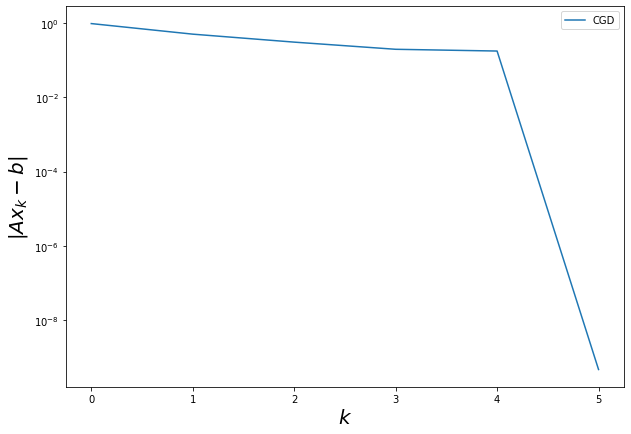

In [9]:
show_cgd()